In [36]:
 import bql
bq = bql.Service()
import bql
import pandas as pd
import bqviz as bqv
import bqplot
import numpy as np
import bqplot as bqp
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from collections import OrderedDict

In [61]:
funds = ['VTI US Equity','VXUS US Equity', 'VWO US Equity', 'BND US Equity','ARKK US Equity']
#Let's create a dictionary for common parameters we will be using
params = {'calc_interval':bq.func.range('2017-12-31','2022-12-31'),
         'currency':'USD',
         'tr_base':'price_if_available'}
#Select the fields we'd like to see - the **params lets us reference the dictionary above
flds = OrderedDict()
#Annualized total return
flds['Return'] = bq.data.ann_total_return(**params)
#Alpha - adjusted for 
flds['J Alpha'] = bq.data.jensen_alpha(**params)
#Sortino Ratio - better accounts for skew vs Sharpe by using downside vol
flds['Sortino Ratio'] = bq.data.sortino_ratio(**params)
flds['Beta'] = bq.data.beta(**params)
flds['Treynor'] = bq.data.treynor_measure(**params)
#Request / response, convert to DataFrame
req = bql.Request(funds, flds)
res = bq.execute(req)
#dictionary comprehension into DataFrame constructor
#dictionary comprehension where key is field name, value is the series for tha field name
#r is each of the response objects that is turned to a DataFrame with .df()
tbl = pd.DataFrame({r.name:r.df()[r.name] for r in res})
tbl

,Return,J Alpha,Sortino Ratio,Beta,Treynor
ID,,,,,
VTI US Equity,0.085235,0.000562,0.687696,0.989423,0.073152
VXUS US Equity,0.008673,-0.001356,0.076359,0.948844,-0.004410
VWO US Equity,-0.006430,-0.003201,-0.051358,0.923349,-0.020889
BND US Equity,0.000258,-0.000657,0.007361,1.023016,-0.012315
ARKK US Equity,-0.029752,-0.160711,-0.122317,1.488050,-0.028635


In [90]:
#import bql
#bq = bql.Service()

bql_item = bq.data.day_to_day_tot_return_gross_dvds(start='2013-01-01', end='2022-12-31', per='m')
bql_universe = ['VTI US Equity','VXUS US Equity', 'VWO US Equity', 'BND US Equity']
bql_request = bql.Request(bql_universe, {"MonthlyReturn":bql_item})
bql_response = bq.execute(bql_request)

data = bql_response[0].df()
data = data.reset_index().pivot(index='DATE', columns='ID', values='MonthlyReturn')
data.columns = ['VTI','VXUS','VWO','BND']
data 


,VTI,VXUS,VWO,BND
DATE,,,,
2013-01-31,-0.006902,0.054176,0.000674,0.024007
2013-02-28,0.005366,0.012816,-0.023676,-0.011411
2013-03-29,0.000787,0.039456,-0.012670,0.009337
2013-04-30,0.010152,0.016057,0.020166,0.035022
2013-05-31,-0.019261,0.024435,-0.050754,-0.033029
...,...,...,...,...
2022-08-31,-0.027980,-0.037285,-0.004598,-0.044868
2022-09-30,-0.041813,-0.092240,-0.100862,-0.099076
2022-10-31,-0.011593,0.081128,-0.028501,0.034083


In [91]:
# Pass the dataframe to HistPlot and apply Bloomberg styles
ex6 = bqv.HistPlot(data,bins=25)

ex6.show()
# Display th

In [145]:
# create an empty dictionary to store the new dataframes
new_dfs = {}

# loop over columns and create new dataframes
for col in data.columns:
    new_df = pd.DataFrame({col: data[col]})
    new_df.index = df.index
    
    # store the new dataframe in the dictionary
    new_dfs[col] = new_df

In [ ]:
ex1 = bqv.OverUnderPlot(new_dfs[data.columns[0]]).set_style()
ex1.show()


# Display the plot




In [ ]:
ex2 = bqv.OverUnderPlot(new_dfs[data.columns[1]]).set_style()
ex2.show()

In [ ]:
ex3 = bqv.OverUnderPlot(new_dfs[data.columns[2]]).set_style()
ex3.show()


In [ ]:
ex4 = bqv.OverUnderPlot(new_dfs[data.columns[3]]).set_style()
ex4.show()

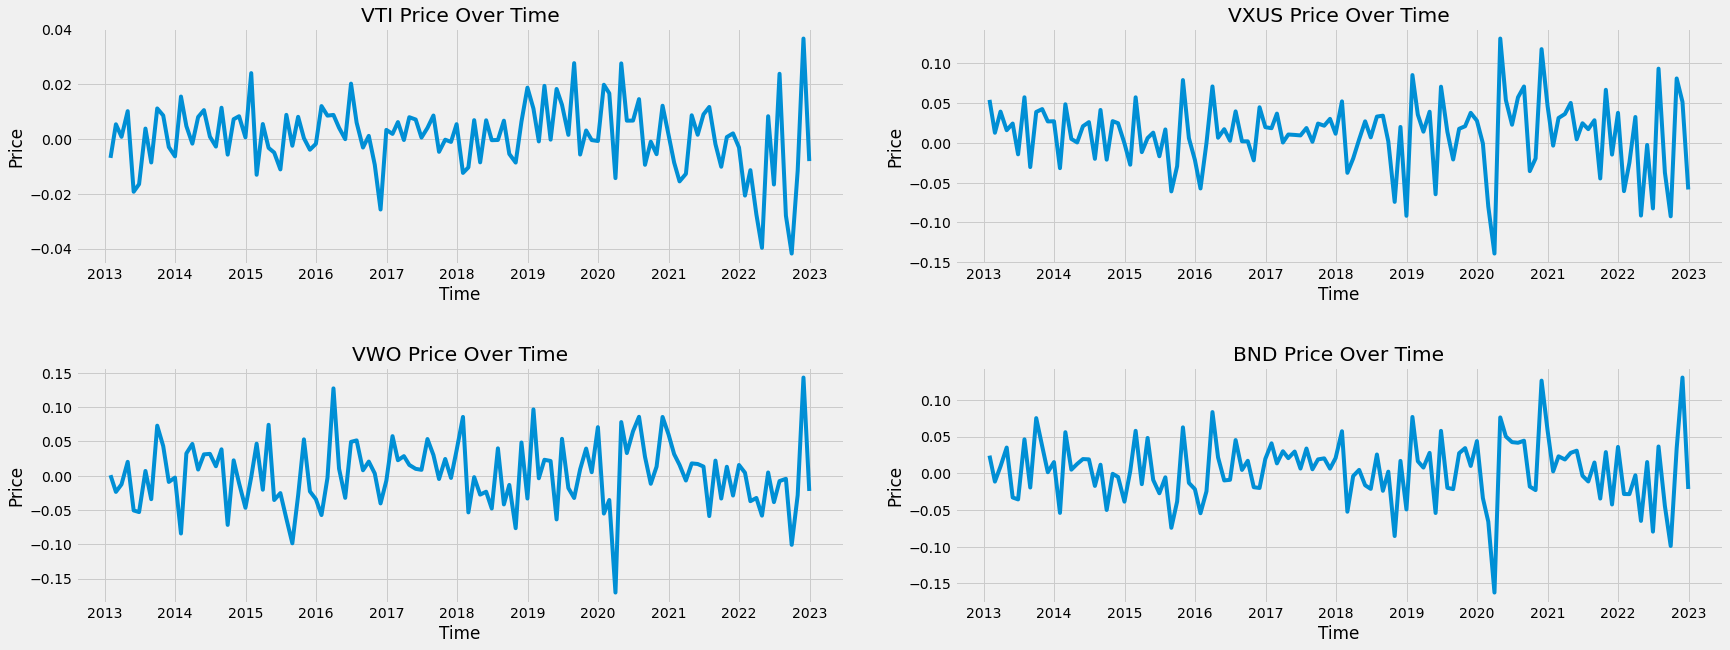

In [127]:
# create grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25, 10))

# plot each stock on a separate subplot
for i, column in enumerate(data.columns):
    row = i // 2
    col = i % 2
    axs[row, col].plot(data[column])
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Price')
    axs[row, col].set_title(f'{column} Price Over Time')

# remove unused subplots and add space between subplots
fig.tight_layout(pad=3.0)

# show the chart
plt.show()

In [63]:
# calculate annual returns of the stocks
returns_annual = data.mean() * 12

# get covariance of returns of the stock
cov_annual = data.cov() * 12

# show hitorical expected returns
(round(returns_annual * 100,2))

ID
BND US Equity      1.09
VTI US Equity     12.60
VWO US Equity      2.85
VXUS US Equity     4.98
dtype: float64

### Simulate 10,000 portfolios with random weights and get the Return, Volatility and Sharpe ratio

In [64]:
np.random.seed(101)
num_portfolios = 10000
num_assets = len(data.columns)
stock_weights = np.zeros((num_portfolios, num_assets))
port_returns = np.zeros(num_portfolios)
port_volatility = np.zeros(num_portfolios)
sharpe_ratio = np.zeros(num_portfolios)

for x in range(num_portfolios):
    # Weights
    weights = np.array(np.random.random(num_assets))
    weights = weights/np.sum(weights)
    
    # Save weights
    stock_weights[x,:] = weights
    
    # Expected return
    port_returns[x] = np.dot(weights, returns_annual)
    
    # Expected volatility
    port_volatility[x] = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    
    # Sharpe Ratio
    sharpe_ratio[x] = port_returns[x]/port_volatility[x]

In [65]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

In [66]:
for counter,symbol in enumerate(data):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in data]

# reorder dataframe columns
df = df[column_order]
df.head(10)

,Returns,Volatility,Sharpe Ratio,BND US Equity Weight,VTI US Equity Weight,VWO US Equity Weight,VXUS US Equity Weight
0,0.067486,0.094500,0.714137,0.401223,0.443388,0.022123,0.133266
1,0.060943,0.111486,0.546640,0.251963,0.306608,0.112865,0.328564
2,0.035816,0.096901,0.369614,0.396923,0.104486,0.304882,0.193709
3,0.064680,0.133912,0.483001,0.084002,0.362809,0.445883,0.107306
4,0.065878,0.138179,0.476761,0.049376,0.356635,0.430760,0.163229
5,0.058248,0.083236,0.699797,0.493194,0.372693,0.034893,0.099220
6,0.074960,0.132545,0.565548,0.081977,0.435963,0.228288,0.253773
7,0.047544,0.114239,0.416178,0.245115,0.180783,0.304602,0.269499
8,0.045542,0.122620,0.371407,0.195941,0.173686,0.463297,0.167077
9,0.055538,0.108925,0.509874,0.274112,0.263078,0.170520,0.292290


### Select the portfolios with 1) Min Volatility, 2) Max Sharpe Ratio and 3) Max Return

In [67]:
# select the portfolios with 1) Min Volatility, 2) Max Sharpe Ratio and 3) Max Return 
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()
max_return = df['Returns'].max()

# use the min, max values to locate and create portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]
max_return_port = df.loc[df['Returns'] == max_return]

### Plot the efficient frontier with all simulated portfolios

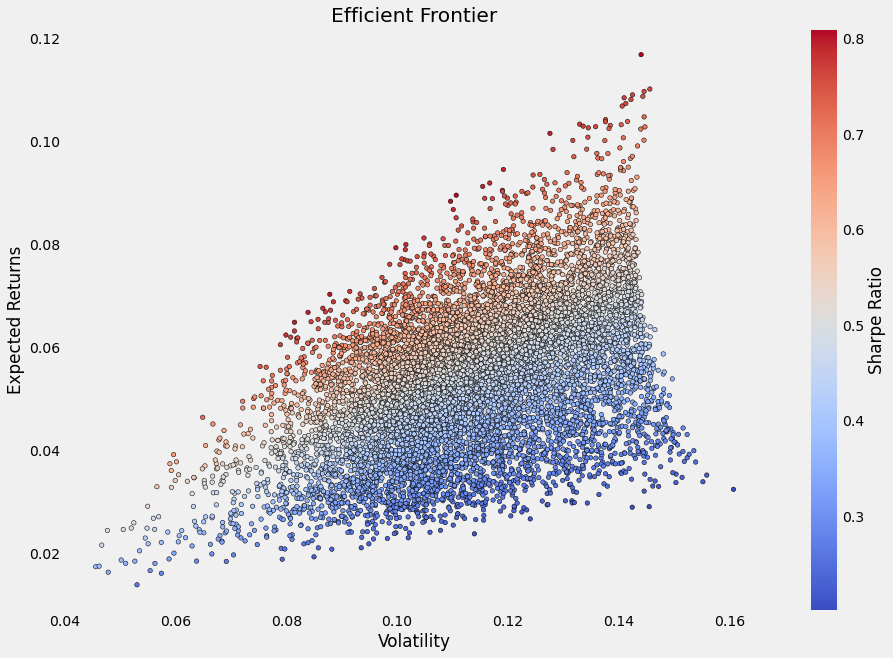

In [68]:
# plot the efficient frontier with all simulated portfolios
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='coolwarm', edgecolors='black', figsize=(14, 10), grid=False)
plt.xlabel('Volatility')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

### Plot the efficient frontier with all simulated portfolios, but idenfity the min vol portfolio and max sharpe portfolio

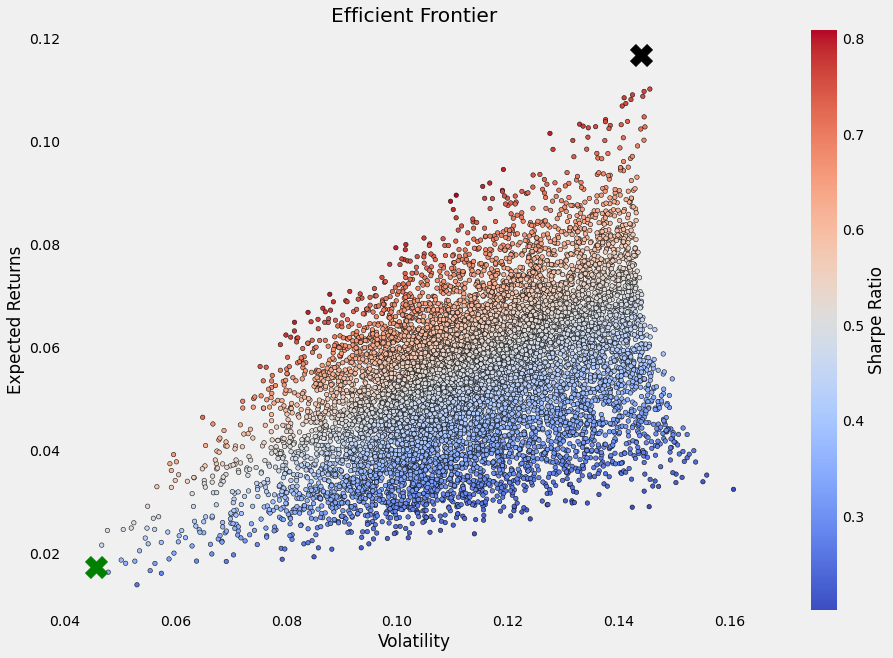

In [69]:
# plot the efficient frontier with all simulated portfolios, but  idenfity the min vol portfolio and max sharpe portfolio
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='coolwarm', edgecolors='black', figsize=(14, 10), grid=False)
plt.xlabel('Volatility')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')

# use the min, max values to locate and create the two special portfolios
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='black', marker='X', s=500)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='green', marker='X', s=500 )

plt.show()

### Portfolio with minimun volatitily

In [70]:
pd.melt((df[df["Volatility"] == df['Volatility'].min()]))

,variable,value
0,Returns,0.017515
1,Volatility,0.045603
2,Sharpe Ratio,0.384065
3,BND US Equity Weight,0.906933
4,VTI US Equity Weight,0.043685
5,VWO US Equity Weight,0.014261
6,VXUS US Equity Weight,0.035121


### Portfolio with max Sharpe Ratio

In [71]:
pd.melt((df[df["Sharpe Ratio"] == df['Sharpe Ratio'].max()]))

,variable,value
0,Returns,0.116867
1,Volatility,0.144052
2,Sharpe Ratio,0.811282
3,BND US Equity Weight,0.042407
4,VTI US Equity Weight,0.913218
5,VWO US Equity Weight,0.040182
6,VXUS US Equity Weight,0.004193


### Portfolio with max Return

In [72]:
pd.melt((df[df["Returns"] == df['Returns'].max()]))

,variable,value
0,Returns,0.116867
1,Volatility,0.144052
2,Sharpe Ratio,0.811282
3,BND US Equity Weight,0.042407
4,VTI US Equity Weight,0.913218
5,VWO US Equity Weight,0.040182
6,VXUS US Equity Weight,0.004193
